## Курсовая работа
### Автор: Дмитрий Громов

* [Задание](#task_definition)
* [Подключение библиотек и скриптов](#code)
* [Загрузка данных](#data_loading)
* [Разведочный анализ данных (EDA)](#eda)
    * [Обзор](#review) 
    * [Приведение типов](#retype)
    * [Чистка данных](#cleaning)
* [Добавление новых признаков](#new_features)    
* [Отбор признаков](#feature_selecting)
* [Разбиение на train и test](#split)
* [Построение модели](#new_model)
* [Кросс-валидация](#validation)
* [Важность признаков](#gravity)
* [Формирование файла с прогнозами](#output_file)

### Задание <a class=anchor id=task_definition>
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


### Подключение библиотек и скриптов <a class=anchor id=code>

In [1]:
# Импортируем необходимые модули
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Отображаем графики в ноутбуке
%matplotlib inline

In [3]:
def create_model(X_train, y_train, X_test, y_test, model):
    """
    """
    model.fit(X_train, y_train)
    y_train_preds=model.predict(X_train)
    y_test_preds=model.predict(X_test)
    
    return y_train_preds, y_test_preds

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных <a class=anchor id=data_loading>

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.shape

(5000, 19)

### Разведочный анализ данных (EDA) <a class=anchor id=eda>

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Построим карту корреляций исходного набора

<AxesSubplot:title={'center':'Исходный набор'}>

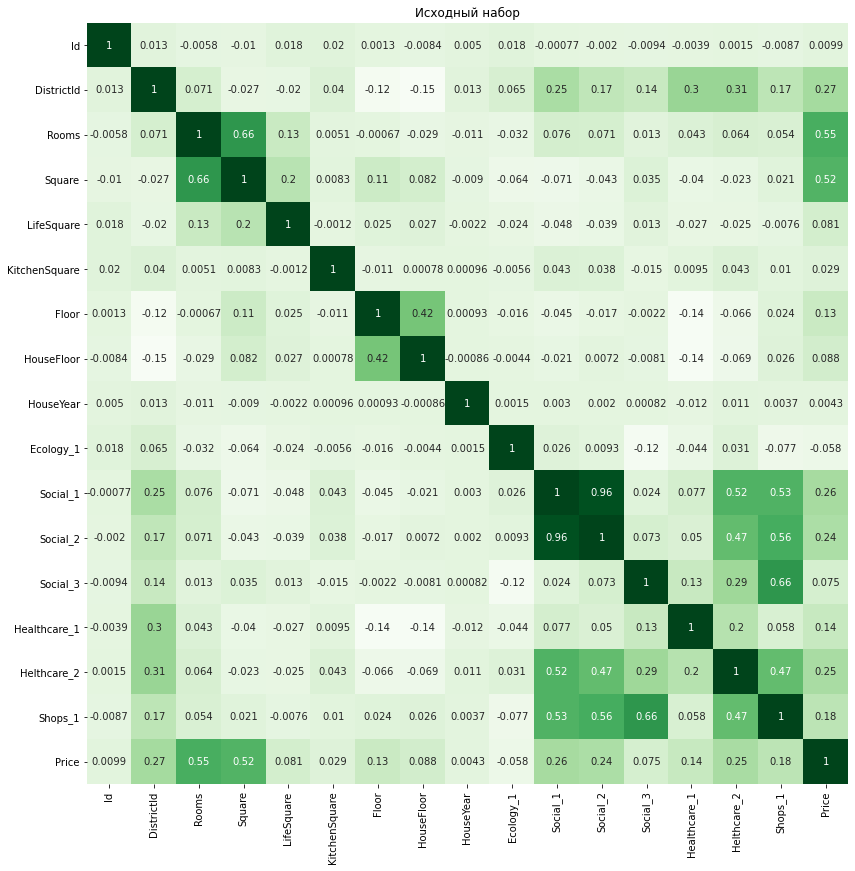

In [10]:
corr = train_df.corr(min_periods=5)
plt.figure(figsize=(14,14))
ax1 = plt.axes()
ax1.set_title("Исходный набор")
sns.heatmap(corr, ax=ax1, cbar=False, square= True, annot=True, cmap='Greens')

### Обзор данных<a class='anchor' id=review>

### Целевая переменная

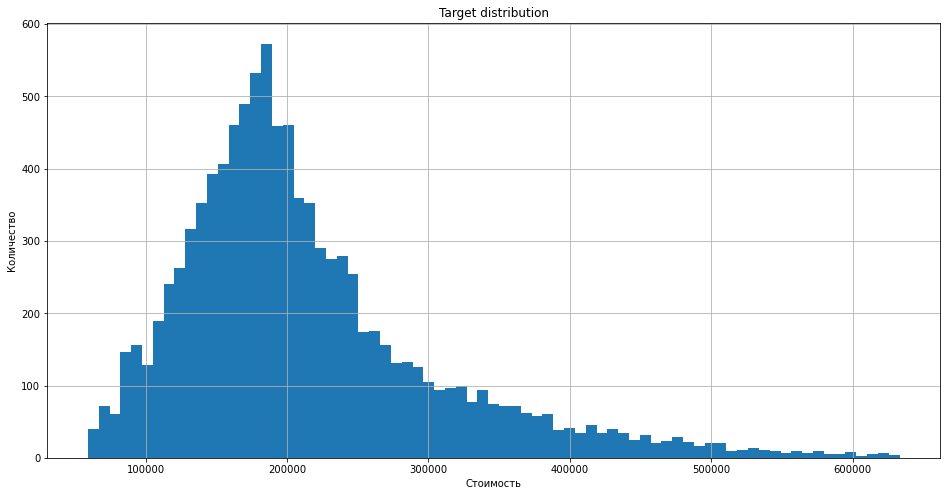

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=75)
plt.ylabel('Количество')
plt.xlabel('Стоимость')

plt.title('Target distribution')
plt.show()

In [12]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Приведение типов <a class="anchor" id=retype>

Что можно сделать:
* <b>Rooms</b>          10000 non-null  float64 - перевожу в int
* <b>Square</b>         10000 non-null  float64 - перевожу в int 
* <b>LifeSquare</b>     7887 non-null   float64 - ЕСТЬ ПРОПУСКИ!!!- избавляемся и переводим в int
* <b>KitchenSquare</b>  10000 non-null  float64 - перевожу в int
* <b>Floor</b>          10000 non-null  int64   - перевожу в int
* <b>HouseFloor</b>     10000 non-null  float64 - перевожу в int
* <b>Healthcare_1</b>   5202 non-null   float64 - ЕСТЬ ПРОПУСКИ!!! - избавляемся

In [13]:
train_df['Rooms'] = train_df['Rooms'].astype('int16')
train_df['Square'] = train_df['Square'].astype('int16')
train_df['KitchenSquare'] = train_df['KitchenSquare'].astype('int16')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int16')

Смотрим на основные статистика набора данных

In [14]:
# df_num = train_df.select_dtypes(include=['int', 'float'])
# df_num.hist(figsize=(16, 20), bins=50)

### Чистка данных <a class='anchor' id='cleaning'>

#### Square

Text(0.5, 1.0, 'Распределение на 64 бинов')

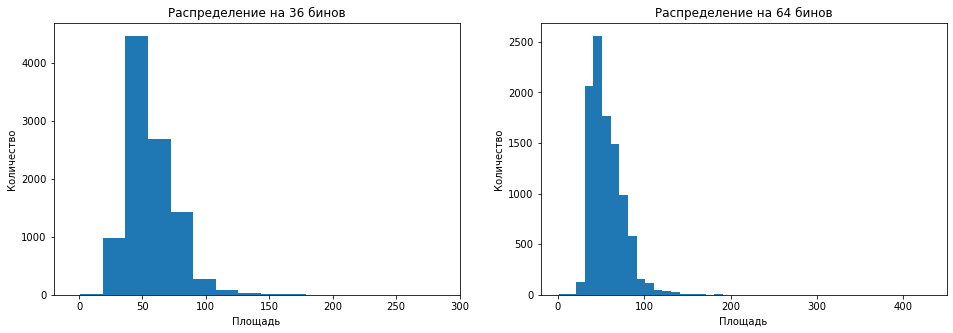

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.hist(train_df['Square'], bins=36)
plt.xlim(-20, 300)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 36 бинов')

plt.subplot(122)
plt.hist(train_df['Square'], bins=64)
plt.xlim(-20, 450)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 64 бинов')


Посмотрим на данные с лимитом по оси-X == 200

Text(0.5, 1.0, 'Square - Распределение на 64 бинов')

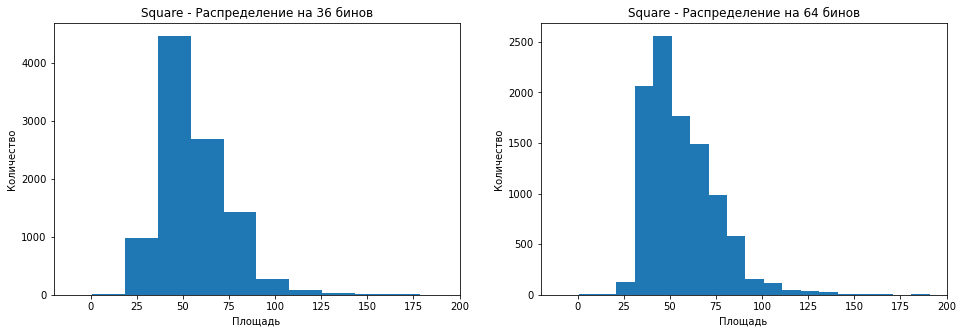

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.hist(train_df['Square'], bins=36)
plt.xlim(-20, 200)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Square - Распределение на 36 бинов')

plt.subplot(122)
plt.hist(train_df['Square'], bins=64)
plt.xlim(-20, 200)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Square - Распределение на 64 бинов')


Посмотрим на пары квантилей (1.5, 98.5), (1, 99), (0.5, 99.5).

Находим квантили 98.5 и 1.5.

In [17]:
train_df[['Square']].quantile(0.015), train_df[['Square']].quantile(0.985)

(Square    30.0
 Name: 0.015, dtype: float64,
 Square    107.015
 Name: 0.985, dtype: float64)

In [18]:
train_df[['Square']].quantile(0.01), train_df[['Square']].quantile(0.99)

(Square    29.0
 Name: 0.01, dtype: float64,
 Square    117.0
 Name: 0.99, dtype: float64)

In [19]:
train_df[['Square']].quantile(0.005), train_df[['Square']].quantile(0.995)

(Square    27.0
 Name: 0.005, dtype: float64,
 Square    132.0
 Name: 0.995, dtype: float64)

In [20]:
# train_df = train_df[train_df['Square'].isnull() |
#                    (train_df['Square'] < train_df['Square'].quantile(.985)) &
#                    (train_df['Square'] > train_df['Square'].quantile(.015))]
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.995)) &
                    (train_df['Square'] > train_df['Square'].quantile(.005))]
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47,29.442751,6,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65,40.049543,8,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44,29.197612,0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53,52.731512,9,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39,23.776169,7,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Делаем копию поля 'Square'.
Округляем значения 'Square' до десятков, полагаю, что точность до метра не нужна. 

Text(0.5, 1.0, 'Распределение на 64 бинов')

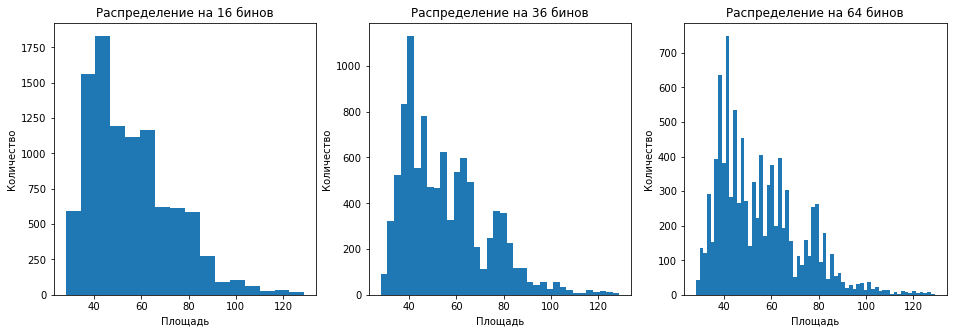

In [21]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.hist(train_df['Square'], bins=16)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 16 бинов')

plt.subplot(132)
plt.hist(train_df['Square'], bins=36)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 36 бинов')

plt.subplot(133)
plt.hist(train_df['Square'], bins=64)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 64 бинов')

In [22]:
train_df['Square_copy'] = train_df['Square']
train_df['Square'] = train_df['Square'].round(decimals=-1)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy
0,14038,35,2,50,29.442751,6,7,9,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,47
1,15053,41,3,60,40.049543,8,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,65
2,4765,53,2,40,29.197612,0,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,44
3,5809,58,2,50,52.731512,9,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,53
4,10783,99,1,40,23.776169,7,11,12,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,39


#### LifeSquare

In [23]:
train_df['LifeSquare'].describe()

count    7801.000000
mean       36.882067
std        86.108937
min         0.370619
25%        22.858801
50%        32.803769
75%        45.056914
max      7480.592129
Name: LifeSquare, dtype: float64

Text(0.5, 1.0, 'Распределение на 64 бинов')

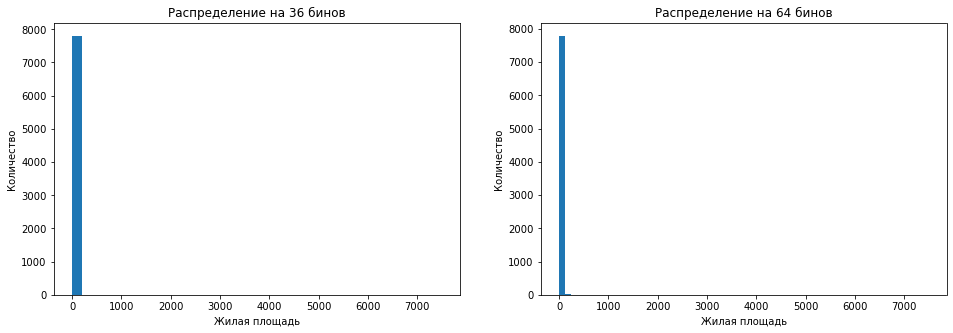

In [24]:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.hist(train_df['LifeSquare'], bins=36)
plt.xlabel('Жилая площадь')
plt.ylabel('Количество')
plt.title('Распределение на 36 бинов')

plt.subplot(122)
plt.hist(train_df['LifeSquare'], bins=64)
plt.xlabel('Жилая площадь')
plt.ylabel('Количество')
plt.title('Распределение на 64 бинов')

In [25]:
train_df[['LifeSquare']].quantile(0.015), train_df[['LifeSquare']].quantile(0.985)

(LifeSquare    4.083905
 Name: 0.015, dtype: float64,
 LifeSquare    85.038779
 Name: 0.985, dtype: float64)

In [26]:
train_df[['LifeSquare']].quantile(0.005), train_df[['LifeSquare']].quantile(0.995)

(LifeSquare    1.836365
 Name: 0.005, dtype: float64,
 LifeSquare    101.525114
 Name: 0.995, dtype: float64)

Считаем, что 'LifeSquare' < 5m2 быть не может и пока присвоем 0

In [27]:
mask = (train_df['LifeSquare'] < 5)
train_df.loc[mask, ['LifeSquare']] = 0


Находим медианые значения 'LifeSquare' исходя из 'Square', 'Rooms'

In [28]:
mask = (train_df['LifeSquare'].isna())
train_df.loc[mask]

agg_data = train_df.groupby(['Square', 'Rooms'])['LifeSquare'].median().round()
agg_data = pd.DataFrame(agg_data)
agg_data.reset_index(inplace=True)
agg_data.isna().sum()
agg_data.dropna(axis=0, inplace=True)
agg_data.rename(columns={'LifeSquare':'MedianLifeSquare'}, inplace=True)

agg_data.head()

,Square,Rooms,MedianLifeSquare
0,30,1,20.0
1,30,2,23.0
2,30,3,28.0
3,40,0,19.0
4,40,1,22.0


In [29]:
merged_df = pd.merge(train_df, agg_data, how='left', on=['Square', 'Rooms'])
merged_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy,MedianLifeSquare
0,14038,35,2,50,29.442751,6,7,9,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.930730,47,32.0
1,15053,41,3,60,40.049543,8,7,9,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.450063,65,43.0
2,4765,53,2,40,29.197612,0,8,12,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.908524,44,28.0
3,5809,58,2,50,52.731512,9,8,17,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.227217,53,32.0
4,10783,99,1,40,23.776169,7,11,12,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531644,39,22.0


In [30]:
merged_df['LifeSquare'].isna().sum()

2085

Заполняем Nan значениями 'MedianLifeSquare'

In [31]:
mask = (merged_df['LifeSquare'].isna())
merged_df.loc[mask, ['LifeSquare']] = merged_df['MedianLifeSquare']

Удаляем колонку 'MedianLifeSquare'

In [32]:
merged_df.drop('MedianLifeSquare', axis=1, inplace=True)

In [33]:
mask = (merged_df['LifeSquare'].isna())
merged_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy
3868,770,28,0,50,NaN,0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,49
4316,456,6,0,80,NaN,0,4,0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,81


In [34]:
train_df = merged_df

Находим медианные значения 'Square' и 'LifeSquare'

In [35]:
median_square = train_df['Square'].median()
median_life_square = train_df['LifeSquare'].median()

print('Square median value:', median_square)
print('LifeSquare median value:', median_life_square)

Square median value: 50.0
LifeSquare median value: 33.090669262923456


Рассчитываем соотношение жилой площади к общей

In [36]:
square_rel = median_life_square / median_square
print(square_rel)

0.6618133852584691


Заполняем оставшиеся пропуски в поле 'LifeSquare' как 'Square' * square_rel

In [37]:
mask = (train_df['LifeSquare'].isna())
train_df.loc[mask, 'LifeSquare'] = train_df['Square'] * square_rel
train_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy
3868,770,28,0,50,33.090669,0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,49
4316,456,6,0,80,52.945071,0,4,0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,81


In [38]:
train_df['LifeSquare'] = train_df['LifeSquare'].astype(int) 

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9886 entries, 0 to 9885
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9886 non-null   int64  
 1   DistrictId     9886 non-null   int64  
 2   Rooms          9886 non-null   int16  
 3   Square         9886 non-null   int16  
 4   LifeSquare     9886 non-null   int64  
 5   KitchenSquare  9886 non-null   int16  
 6   Floor          9886 non-null   int64  
 7   HouseFloor     9886 non-null   int16  
 8   HouseYear      9886 non-null   int64  
 9   Ecology_1      9886 non-null   float64
 10  Ecology_2      9886 non-null   object 
 11  Ecology_3      9886 non-null   object 
 12  Social_1       9886 non-null   int64  
 13  Social_2       9886 non-null   int64  
 14  Social_3       9886 non-null   int64  
 15  Healthcare_1   5149 non-null   float64
 16  Helthcare_2    9886 non-null   int64  
 17  Shops_1        9886 non-null   int64  
 18  Shops_2 

Находим записи где ('LifeSquare' > 'Square') & ('KitchenSquare < 1) и заполняем их по формуле 
'LifeSquare' = 'Square'

'LifeSquare' как 'Square' * square_rel

In [40]:
mask = (train_df['LifeSquare'] > train_df['Square']) & \
        (train_df['KitchenSquare'] <= 1)
train_df.loc[mask, 'LifeSquare'] = train_df['Square']
# train_df[mask]

Находим все записи где 'LifeSquare' > 'Square' и присваеваем 'LifeSquare' = 'Square' 

In [41]:
mask = (train_df['Square'] < train_df['LifeSquare'])
train_df.loc[mask, 'LifeSquare'] = train_df['Square']

Text(0.5, 1.0, 'Распределение на 64 бинов')

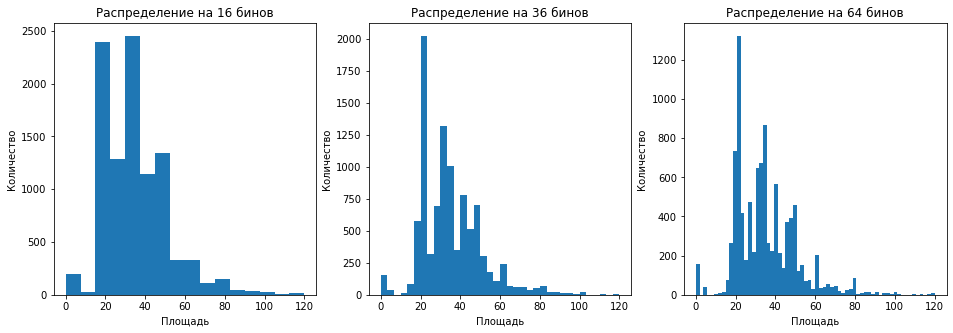

In [42]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.hist(train_df['LifeSquare'], bins=16)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 16 бинов')

plt.subplot(132)
plt.hist(train_df['LifeSquare'], bins=36)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 36 бинов')

plt.subplot(133)
plt.hist(train_df['LifeSquare'], bins=64)
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.title('Распределение на 64 бинов')

#### Rooms

In [43]:
train_df['Rooms'].describe()

count    9886.000000
mean        1.889945
std         0.833435
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        19.000000
Name: Rooms, dtype: float64

In [44]:
train_df['Rooms'].value_counts()

2     3873
1     3643
3     2208
4      139
5       14
0        5
10       2
19       1
6        1
Name: Rooms, dtype: int64

Смотрим на данные где значения 'Rooms' >= 10 | 'Rooms' < 1 

In [45]:
mask = (train_df['Square'] < 100) & ((train_df['Rooms'] >= 10) | (train_df['Rooms'] < 1)) 
train_df[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy
376,5927,57,10,60,36,10,22,22,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,59
1442,8491,1,19,40,21,7,17,17,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,42
2244,7317,27,0,40,19,0,13,0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,41
3868,770,28,0,50,33,0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,49
4316,456,6,0,80,52,0,4,0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,81
6085,3159,88,0,40,19,9,9,16,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,38
8735,9443,27,0,90,85,0,5,15,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,87
8749,14865,9,10,60,38,10,3,2,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,60


In [46]:
train_df['Rooms'].describe()

count    9886.000000
mean        1.889945
std         0.833435
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        19.000000
Name: Rooms, dtype: float64

Предполагаю, что данные записи должны иметь значение 'Rooms' == 1,
что и сделаю

In [47]:
# train_df.loc[mask, 'Rooms'] = 1
# train_df[mask]
train_df = train_df[train_df['Rooms'].isnull() |
    (train_df['Rooms'] < train_df['Rooms'].quantile(.99)) &
    (train_df['Rooms'] > train_df['Rooms'].quantile(.01))]


#### KitchenSquare

In [48]:
train_df['KitchenSquare'].describe()

count    6081.000000
mean        6.059036
std         5.387940
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max       123.000000
Name: KitchenSquare, dtype: float64

Принимаю следующее:
* Примем за минимальную площадь кухни, значение 4м2
* Все значения 'KitchenSquare' <= 1, при 'Square' == 'LifeSquare' сбрасываю в 0
* Все значения 'KitchenSquare' <= 4, при ('Square' - 'LifeSquare') > 4 рассчитываю как 'Square' - 'LifeSquare'
* Все значения 'KitchenSquare' в пределах 0 < KitchenSquare < 4, проставляю в 4м2
* Все значения, где 'KitchenSquare' > 'Square' проинициализируем значениями по формуле
    'Square' - 'LifeSquare'
* Вычислим среднее отношение 'KitchenSquare' к 'Square'


     

In [49]:
KitchenSquareMin = 4

In [50]:
# mask = ((train_df['KitchenSquare'] + train_df['LifeSquare']) > train_df['Square'])
mask = (train_df['LifeSquare'] == train_df['Square']) & \
        (train_df['KitchenSquare'] <= 1)
train_df.loc[mask, 'KitchenSquare'] = 0
# train_df.loc[mask]

In [51]:
mask = (train_df['KitchenSquare'] < 4) & \
        ((train_df['Square'] - train_df['LifeSquare']) > 4)
train_df.loc[mask, 'KitchenSquare'] = (train_df['Square'] - train_df['LifeSquare'])
# train_df.loc[mask]

In [52]:
mask = (train_df['KitchenSquare'] < 4) & (train_df['KitchenSquare'] > 0)
train_df.loc[mask, 'KitchenSquare'] = 4
# train_df.loc[mask]

In [53]:
mask = (train_df['KitchenSquare'] > train_df['Square'])
train_df.loc[mask, 'KitchenSquare'] = (train_df['Square'] - train_df['LifeSquare'])
train_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_copy
1842,4265,161,2,50,32,18,7,17,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,261125.669724,53
2936,7441,62,3,110,110,0,3,3,2015,0.072158,...,B,2,629,1,NaN,0,0,A,315245.521059,114
5826,16593,52,2,60,35,25,15,17,1977,0.371149,...,B,34,7065,1,750.0,2,5,B,185993.474671,64
9777,12918,23,2,50,50,0,3,17,2017,0.005767,...,B,1,388,0,NaN,0,0,B,88150.012510,51
9783,2737,27,3,120,120,0,5,10,2015,0.017647,...,B,2,469,0,NaN,0,0,B,234194.837047,123


In [54]:
train_df['KitchenSquare'].describe()

count    6081.000000
mean       12.665516
std        12.188835
min         0.000000
25%         6.000000
50%         9.000000
75%        12.000000
max       130.000000
Name: KitchenSquare, dtype: float64

Возвращаем значения ''Square'

In [55]:
# train_df['Square_copy'] = train_df['Square_copy'].astype(int)
train_df['Square'] = train_df['Square_copy']
train_df.drop(columns=['Square_copy'], inplace=True)

#### HouseFloor, Floor

In [56]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  30,  31,  32,  37,  39,  40,  45,  48,  99, 117],
      dtype=int16)

In [57]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 42])

Делаю следующее:
* Вычисляем медиану этажности
* Находим записи с полем 'HouseFloor' == 0 и инициализируем их медианой
* Находим записи, этаж которых превышает этажность дома и инициализируем их по формуле 'Floor' = 'HouseFloor'

In [58]:
mask = (train_df['HouseFloor'] == 0)
train_df[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2,80,47,33,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3,118,68,52,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3,106,0,110,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2,60,35,25,16,0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3,104,100,0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9484,2553,62,2,56,35,25,9,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,153997.912192
9518,14936,27,3,103,60,40,8,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,225901.938089
9658,9384,59,3,98,60,40,14,0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9766,11441,62,2,71,70,0,5,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.624543


In [59]:
house_floor_median = train_df['HouseFloor'].median()
# print(house_floor_median)

In [60]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [61]:
mask = (train_df['Floor'] > train_df['HouseFloor'])
train_df.loc[mask, 'Floor'] = train_df['HouseFloor']
# train_df.loc[mask]

Проверяем

In [62]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 28, 42])

In [63]:
train_df['HouseFloor'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  30,  31,  32,  37,  39,  40,  45,  48,  99, 117],
      dtype=int16)

In [64]:
mask = (train_df['Floor'] > train_df['HouseFloor'])
train_df[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


#### HouseYear

In [65]:
train_df['HouseYear'].value_counts().sort_index()

1914      1
1916      1
1917      2
1918      4
1919      2
       ... 
2017    168
2018    103
2019     37
2020     11
4968      1
Name: HouseYear, Length: 94, dtype: int64

In [66]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Healthcare_1

In [67]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
5     990.0
Name: Healthcare_1, dtype: float64

In [68]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

****

### Добавление новых признаков  <a class='anchor' id='new_features'>

#### MedianHouseFloorPrice

Попробуем найти медиану стоимости по 'DistrictId', 'HouseFloor', то есть зависимость стоимости от округа и этажности дома

In [69]:
agg_data = train_df.groupby(['DistrictId', 'HouseFloor'])['Price'].median().round()
agg_df = pd.DataFrame(agg_data) 
agg_df.reset_index(inplace=True)
agg_df.rename(columns={'Price':'MedianHouseFloorPrice'}, inplace=True)
agg_df.head()

,DistrictId,HouseFloor,MedianHouseFloorPrice
0,0,5,174679.0
1,0,8,339229.0
2,0,9,182373.0
3,0,10,384840.0
4,0,12,242250.0


In [70]:
merged_df = train_df.merge(agg_df, how='left', on=['DistrictId', 'HouseFloor'])
train_df = merged_df
merged_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedianHouseFloorPrice
0,14038,35,2,47,29,6,7,9,1969,0.089040,...,B,33,7976,5,900.0,0,11,B,184966.930730,198914.0
1,15053,41,3,65,40,8,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,207746.0
2,4765,53,2,44,29,11,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,264603.0
3,5809,58,2,53,50,9,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,180055.0
4,12915,59,3,80,46,12,5,17,2011,0.309479,...,B,35,7715,4,990.0,0,6,B,215898.447742,345059.0


#### MedianHouseFloorFloorPrice

Попробуем найти медиану стоимости по 'DistrictId', 'HouseFloor', 'Floor', то есть зависимость стоимости от округа, этажности дома и самого этажа

In [71]:
agg_data = train_df.groupby(['DistrictId', 'HouseFloor', 'Floor'])['Price'].median().round()
agg_df = pd.DataFrame(agg_data) 
agg_df.reset_index(inplace=True)
agg_df.rename(columns={'Price':'MedianHouseFloorFloorPrice'}, inplace=True)
agg_df.head()

,DistrictId,HouseFloor,Floor,MedianHouseFloorFloorPrice
0,0,5,3,167238.0
1,0,5,4,177321.0
2,0,5,5,168890.0
3,0,8,4,339229.0
4,0,9,1,149787.0


In [72]:
merged_df = train_df.merge(agg_df, how='left', on=['DistrictId', 'HouseFloor', 'Floor'])
train_df = merged_df
merged_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedianHouseFloorPrice,MedianHouseFloorFloorPrice
0,14038,35,2,47,29,6,7,9,1969,0.089040,...,33,7976,5,900.0,0,11,B,184966.930730,198914.0,213685.0
1,15053,41,3,65,40,8,7,9,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.450063,207746.0,246774.0
2,4765,53,2,44,29,11,8,12,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.908524,264603.0,286621.0
3,5809,58,2,53,50,9,8,17,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.227217,180055.0,178831.0
4,12915,59,3,80,46,12,5,17,2011,0.309479,...,35,7715,4,990.0,0,6,B,215898.447742,345059.0,215898.0


#### MedianSocial_1, MedianSocial_2

Находим медиану для Social_1 по округам

In [73]:
agg_data = train_df.groupby(['DistrictId'])['Social_1'].median().round()
agg_df = pd.DataFrame(agg_data) 
agg_df.reset_index(inplace=True)
agg_df.rename(columns={'Social_1':'MedianSocial_1'}, inplace=True)
agg_df.head()

,DistrictId,MedianSocial_1
0,0,25.0
1,1,1.0
2,2,35.0
3,3,43.0
4,4,17.0


In [74]:
merged_df = train_df.merge(agg_df, how='left', on=['DistrictId'])
train_df = merged_df

Находим медиану для Social_2 по округам

In [75]:
agg_data = train_df.groupby(['DistrictId'])['Social_2'].median().round()
agg_df = pd.DataFrame(agg_data) 
agg_df.reset_index(inplace=True)
agg_df.rename(columns={'Social_2':'MedianSocial_2'}, inplace=True)
agg_df.head()

,DistrictId,MedianSocial_2
0,0,4756.0
1,1,264.0
2,2,7715.0
3,3,10621.0
4,4,4334.0


In [76]:
merged_df = train_df.merge(agg_df, how='left', on=['DistrictId'])
train_df = merged_df

#### MedianHealthcare_1

Находим медиану для Healthcare_1 по округам

In [77]:
agg_data = train_df.groupby(['DistrictId'])['Healthcare_1'].median().round()
agg_df = pd.DataFrame(agg_data) 
agg_df.reset_index(inplace=True)
agg_df.rename(columns={'Healthcare_1':'MedianHealthcare_1'}, inplace=True)
agg_df.head()

,DistrictId,MedianHealthcare_1
0,0,2857.0
1,1,900.0
2,2,990.0
3,3,30.0
4,4,2220.0


In [78]:
merged_df = train_df.merge(agg_df, how='left', on=['DistrictId'])
train_df = merged_df

#### PopulationDensity

Создадим поле 'PopulationDensity' на основе иформации о кол-ве домов разной этажности в каждом округе

In [79]:
agg_data = train_df.groupby(['DistrictId', 'HouseFloor'],as_index=False).size()
agg_df = pd.DataFrame(agg_data)
agg_df.rename(columns={'size':'Count'}, inplace=True)
agg_df['PopulationDensity'] = agg_df['HouseFloor'] * agg_df['Count']
agg_df = agg_df.groupby(['DistrictId']).agg({'PopulationDensity':'sum'}, as_index=False)
agg_df.reset_index(inplace=True)

In [80]:
train_df = train_df.merge(agg_df, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,MedianHouseFloorPrice,MedianHouseFloorFloorPrice,MedianSocial_1,MedianSocial_2,MedianHealthcare_1,PopulationDensity
0,14038,35,2,47,29,6,7,9,1969,0.089040,...,0,11,B,184966.930730,198914.0,213685.0,33.0,7976.0,900.0,144
1,15053,41,3,65,40,8,7,9,1978,0.000070,...,1,16,B,300009.450063,207746.0,246774.0,36.0,10055.0,900.0,679
2,4765,53,2,44,29,11,8,12,1968,0.049637,...,1,3,B,220925.908524,264603.0,286621.0,34.0,7759.0,229.0,1768
3,5809,58,2,53,50,9,8,17,1977,0.437885,...,0,5,B,175616.227217,180055.0,178831.0,23.0,5469.0,1084.0,1045
4,12915,59,3,80,46,12,5,17,2011,0.309479,...,0,6,B,215898.447742,345059.0,215898.0,37.0,7687.0,176.0,843


Оптимизируем набор данных

In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6081 entries, 0 to 6080
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          6081 non-null   int64  
 1   DistrictId                  6081 non-null   int64  
 2   Rooms                       6081 non-null   int16  
 3   Square                      6081 non-null   int16  
 4   LifeSquare                  6081 non-null   int64  
 5   KitchenSquare               6081 non-null   int64  
 6   Floor                       6081 non-null   int64  
 7   HouseFloor                  6081 non-null   int16  
 8   HouseYear                   6081 non-null   int64  
 9   Ecology_1                   6081 non-null   float64
 10  Ecology_2                   6081 non-null   object 
 11  Ecology_3                   6081 non-null   object 
 12  Social_1                    6081 non-null   int64  
 13  Social_2                    6081 

In [82]:
cat_columns = train_df.select_dtypes(include='object').columns.tolist()
cat_columns

['Ecology_2', 'Ecology_3', 'Shops_2']

In [83]:
train_df.drop(columns=cat_columns, inplace=True)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.01 MB
Memory usage after optimization is: 0.37 MB
Decreased by 63.8%


In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6081 entries, 0 to 6080
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          6081 non-null   int16  
 1   DistrictId                  6081 non-null   int16  
 2   Rooms                       6081 non-null   int8   
 3   Square                      6081 non-null   int16  
 4   LifeSquare                  6081 non-null   int8   
 5   KitchenSquare               6081 non-null   int16  
 6   Floor                       6081 non-null   int8   
 7   HouseFloor                  6081 non-null   int8   
 8   HouseYear                   6081 non-null   int16  
 9   Ecology_1                   6081 non-null   float32
 10  Social_1                    6081 non-null   int8   
 11  Social_2                    6081 non-null   int16  
 12  Social_3                    6081 non-null   int16  
 13  Healthcare_1                6081 

****

### Отбор признаков <a class='anchor' id='feature_selecting'>

Строим карту корреляций полученного набора

<AxesSubplot:title={'center':'Полученный набор'}>

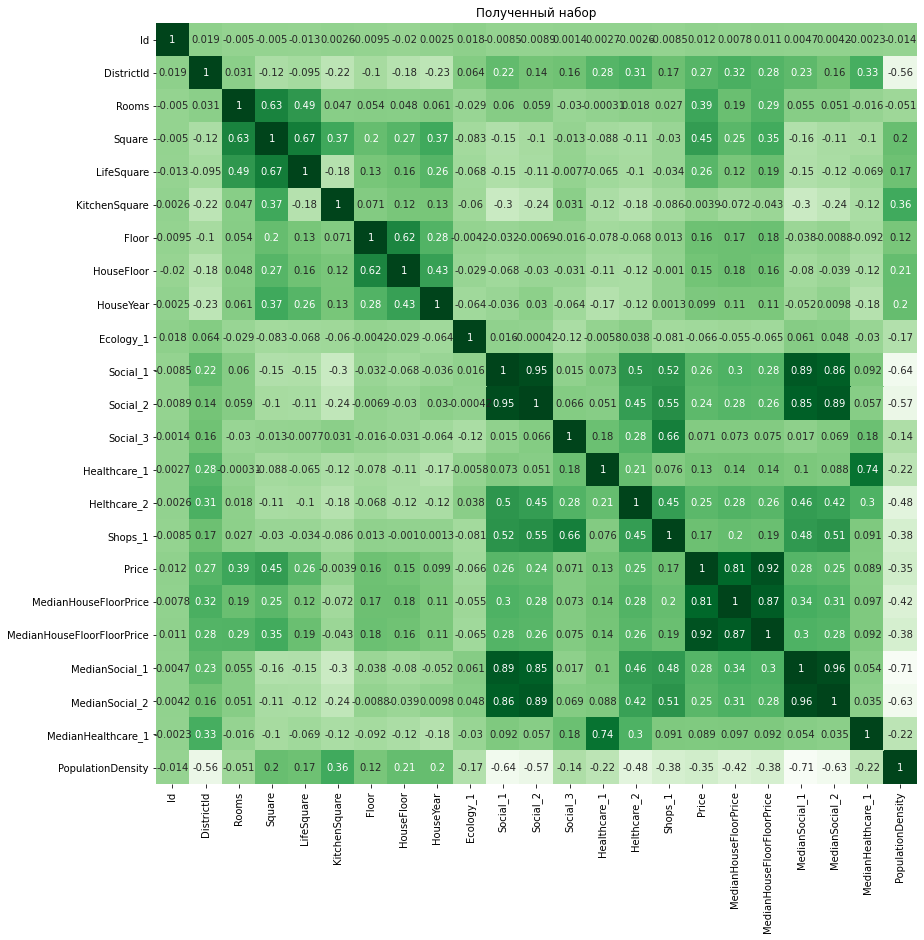

In [85]:
corr = train_df.corr(min_periods=5)
plt.figure(figsize=(14,14))
ax1 = plt.axes()
ax1.set_title("Полученный набор")
sns.heatmap(corr, ax=ax1, cbar=False, square= True, annot=True, cmap='Greens')

Странным образом снизилась корреляция между площадью и ценой?!

In [86]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'MedianHouseFloorPrice',
 'MedianHouseFloorFloorPrice',
 'MedianSocial_1',
 'MedianSocial_2',
 'MedianHealthcare_1',
 'PopulationDensity']

In [87]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', \
                 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', \
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', \
                 'Helthcare_2', 'Shops_1', 'MedianSocial_1', 'MedianSocial_2', \
                 'MedianHealthcare_1', \
                 'PopulationDensity', 'MedianHouseFloorPrice', 'MedianHouseFloorFloorPrice']

target_name = 'Price'

In [88]:
train_df.shape, test_df.shape

((6081, 23), (5000, 19))

****

### Разбиение на train и test <a class='anchor' id='split'>

In [89]:
X = train_df[feature_names]
y = train_df[target_name]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6081 entries, 0 to 6080
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  6081 non-null   int16  
 1   Rooms                       6081 non-null   int8   
 2   Square                      6081 non-null   int16  
 3   LifeSquare                  6081 non-null   int8   
 4   KitchenSquare               6081 non-null   int16  
 5   Floor                       6081 non-null   int8   
 6   HouseFloor                  6081 non-null   int8   
 7   HouseYear                   6081 non-null   int16  
 8   Ecology_1                   6081 non-null   float32
 9   Social_1                    6081 non-null   int8   
 10  Social_2                    6081 non-null   int16  
 11  Social_3                    6081 non-null   int16  
 12  Healthcare_1                6081 non-null   float32
 13  Helthcare_2                 6081 

****

### Построение модели <a class='anchor' id='new_model'>

#### GradientBoostingRegressor

In [92]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=8,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)


Train R2:	0.967
Test R2:	0.882


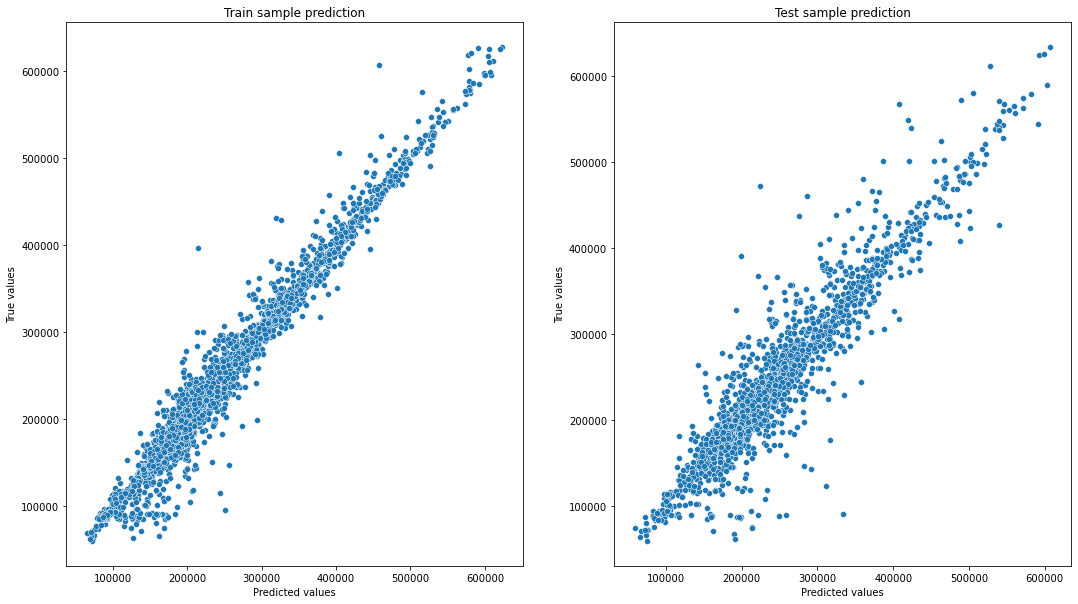

In [93]:
y_train_preds, y_test_preds = create_model(X_train, y_train, X_test, y_test, gb_model)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Я получил:
* Train R2:	0.967
* Test R2:	0.882 - неплохо

#### Кросс-валидация <a class='anchor' id='validation'>

In [94]:
cv_score = cross_val_score(gb_model,
                X.fillna(-9999),
                y, scoring='r2',
                cv=KFold(n_splits=5, shuffle=True, random_state=21)
            )
cv_score

array([0.88949356, 0.87358903, 0.88209029, 0.88621239, 0.87396638])

In [95]:
cv_score.mean(), cv_score.std()

(0.881070332518264, 0.006401060309845192)

In [96]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.8746692722084188, 0.8874713928281093)

Вроде норм, в 0.6 укладываемся.

#### Важность признаков <a class='anchor' id='gravity'>

In [97]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['Feature_name', 'Gravity'])

feature_importances.sort_values(by='Gravity', ascending=False)

,Feature_name,Gravity
20,MedianHouseFloorFloorPrice,0.890101
2,Square,0.031945
7,HouseYear,0.010572
1,Rooms,0.009607
19,MedianHouseFloorPrice,0.007236
3,LifeSquare,0.007091
12,Healthcare_1,0.005212
18,PopulationDensity,0.004890
8,Ecology_1,0.004382
4,KitchenSquare,0.003696


Как видно, зависимость стоимости от округа, этажа и этажности дома даёт максимальный вклад 

****

### Формирование файла с прогнозами <a class='anchor' id='output_file'>

In [98]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./DGromov_predictions.csv", index=False)

In [99]:
pred_df = pd.read_csv("./DGromov_predictions.csv")
pred_df.head(n=2)

,Id,Price
0,725,540789
1,15856,981946


In [100]:
test_df.shape[0]

5000